In [1]:
import torch
from torch import nn
from collections import OrderedDict
import numpy as np

In [120]:
class CoDA_AE(nn.Module):
    
    def __init__(self, encoder_shape, decoder_shape):
        super(CoDA_AE, self).__init__()
        
        #define a list with each element the input and output dim of the layer
        layer_list = [[encoder_shape[i], encoder_shape[i+1]] for i in range(0, len(encoder_shape)-1)]
        
        encoder_dict = OrderedDict()

        for i in range(0,len(layer_list)):
            encoder_dict["layer"  + str(i)] = nn.Linear(layer_list[i][0], layer_list[i][1])
            encoder_dict["layer_ac"  + str(i)] = nn.ELU()


        self.encoder = nn.Sequential(encoder_dict)
        
        layer_list = [[decoder_shape[i], decoder_shape[i+1]] for i in range(0, len(decoder_shape)-1)]
        
        decoder_dict = OrderedDict()

        for i in range(0,len(layer_list)):
            decoder_dict["layer"  + str(i)] = nn.Linear(layer_list[i][0], layer_list[i][1])
            decoder_dict["layer_ac"  + str(i)] = nn.ELU()

        self.decoder = nn.Sequential(decoder_dict)
        
        
    def forward(self,x):
        #run the encoding and store the low level representation as A
        #TODO
        #need to create the clr transform of X, then feed both that and X into the encoder
        #easier to have encoder_shape as hidden layers, and have the desired dimension and input size as params
        
        
        self.A = self.encoder(x)
        self.reconstruction = self.decoder(self.A)
        return self.reconstruction
        

In [156]:
X = features
autoencoder = CoDA_AE([3,100,2], [2,3])
print (autoencoder)
#define the CoDA-PCA loss
loss_function = CoDA_Loss()
optim = torch.optim.SGD(autoencoder.parameters(), lr = 0.001)
    
for epoch in range(0,1000):
    out = autoencoder.forward(torch.FloatTensor(X))
    loss = loss_function(out, torch.FloatTensor(X))
        
    optim.zero_grad()
        
    loss.backward()
    optim.step()
        
    epoch += 1
    
    #print("epoch {}, loss {}".format(epoch, loss))

CoDA_AE(
  (encoder): Sequential(
    (layer0): Linear(in_features=3, out_features=100, bias=True)
    (layer_ac0): ELU(alpha=1.0)
    (layer1): Linear(in_features=100, out_features=2, bias=True)
    (layer_ac1): ELU(alpha=1.0)
  )
  (decoder): Sequential(
    (layer0): Linear(in_features=2, out_features=3, bias=True)
    (layer_ac0): ELU(alpha=1.0)
  )
)


In [101]:
class CoDA_Loss(torch.nn.Module):
    
    def __init__(self):
        super(CoDA_Loss,self).__init__()
        
    def forward(self,Y,X):
        #X is original data, Y is CoDA reconstruction
        #input needs to be normalised by g(x) (geometric mean) for X_hat
        #TODO centering matrix? Reduce mean? Mask?  
        X_check = check(X)
        coda_loss = torch.sum(torch.exp(Y)) - torch.sum(X_check * Y)
        return coda_loss

def check(X):
    #assume input is tensor so we can use the numpy() method
    assert type(X) == torch.Tensor
    gmean = torch.prod(X, 1) ** (1./X.shape[1])
    return torch.div(X.t(), gmean).t()

In [128]:
C = CoDA_Loss()
C.forward(torch.FloatTensor([[2,2,2,4], [1,3,3,4], [1,4,3,4]]), torch.FloatTensor([[2,2,3,4], [1,1,1,1], [1,4,3,4]]))

tensor(267.8988)

CoDA_AE(
  (encoder): Sequential(
    (layer0): Linear(in_features=3, out_features=100, bias=True)
    (layer_ac0): ELU(alpha=1.0)
    (layer1): Linear(in_features=100, out_features=2, bias=True)
    (layer_ac1): ELU(alpha=1.0)
  )
  (decoder): Sequential(
    (layer0): Linear(in_features=2, out_features=3, bias=True)
    (layer_ac0): ELU(alpha=1.0)
  )
)
epoch 1000, loss -218.8839111328125
epoch 2000, loss -228.36953735351562
epoch 3000, loss -232.01467895507812
epoch 4000, loss -234.227783203125
epoch 5000, loss -239.3748779296875
epoch 6000, loss -249.12100219726562
epoch 7000, loss -267.6860046386719
epoch 8000, loss -271.83929443359375
epoch 9000, loss -274.2187194824219
epoch 10000, loss -275.87298583984375


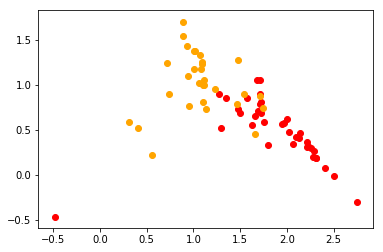

In [166]:
import pandas as pd 
import matplotlib.pyplot as plt

data_9 = pd.read_csv("Data 9. Urinary excretions (mg_per_24hr) of steroid metabolites for 37 adults and 30 normal children.csv")
adult_inds = np.where(data_9['Adult/Child'] == 'A')
child_inds = np.where(data_9['Adult/Child'] == 'C')

adult = data_9.to_numpy()[adult_inds]
child = data_9.to_numpy()[child_inds]
features = data_9[data_9.columns[2:]].to_numpy()


features = np.array([feat/sum(feat) for feat in features])



X = features
autoencoder = CoDA_AE([3,100,2], [2,3])
print (autoencoder)
#define the CoDA-PCA loss
loss_function = CoDA_Loss()
optim = torch.optim.SGD(autoencoder.parameters(), lr = 0.001)
    
for epoch in range(0,10000):
    out = autoencoder.forward(torch.FloatTensor(X))
    loss = loss_function(out, torch.FloatTensor(X))
        
    optim.zero_grad()
        
    loss.backward()
    optim.step()
        
    epoch += 1
    
    if (epoch % 1000 == 0):
        print("epoch {}, loss {}".format(epoch, loss))
    
test = autoencoder.A.detach().numpy()



# # pca_clr = CodaPCA.CLRPCA(2)
# # pca_clr.fit(features)
# # test = pca_clr.transform(features)

# pca = CodaPCA.CodaPCA(2,lrate=1e-3,nn_shape=[100,100], alg=CodaPCA.Alg.CODAPCA)
# pca.fit(features)


# test = pca.transform(features)

plt.scatter(x = test[adult_inds][:,0], y = test[adult_inds][:,1], c ="red")
plt.scatter(x = test[child_inds][:,0], y = test[child_inds][:,1], c ="orange")


plt.show()
